In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# Set plot style
sns.set_style("whitegrid")


In [24]:
# Load Raw Data

DATA_PATH = "../data/raw/"

train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
stores = pd.read_csv(os.path.join(DATA_PATH, "stores.csv"))
oil = pd.read_csv(os.path.join(DATA_PATH, "oil.csv"))
transactions = pd.read_csv(os.path.join(DATA_PATH, "transactions.csv"))

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Transactions shape:", transactions.shape)


Train shape: (3000888, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Transactions shape: (83488, 3)


In [3]:
train.head()
train.info()
train.describe()


<class 'pandas.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         str    
 2   store_nbr    int64  
 3   family       str    
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), str(2)
memory usage: 137.4 MB


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


Check Missing Values

In [4]:
# Missing values summary
missing_summary = train.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


Series([], dtype: int64)

In [5]:
oil.isnull().sum()


date           0
dcoilwtico    43
dtype: int64

Convert Date to Datetime

In [6]:
# Convert date to datetime
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])


In [7]:
train.dtypes


id                      int64
date           datetime64[us]
store_nbr               int64
family                    str
sales                 float64
onpromotion             int64
dtype: object

Basic Time Series View

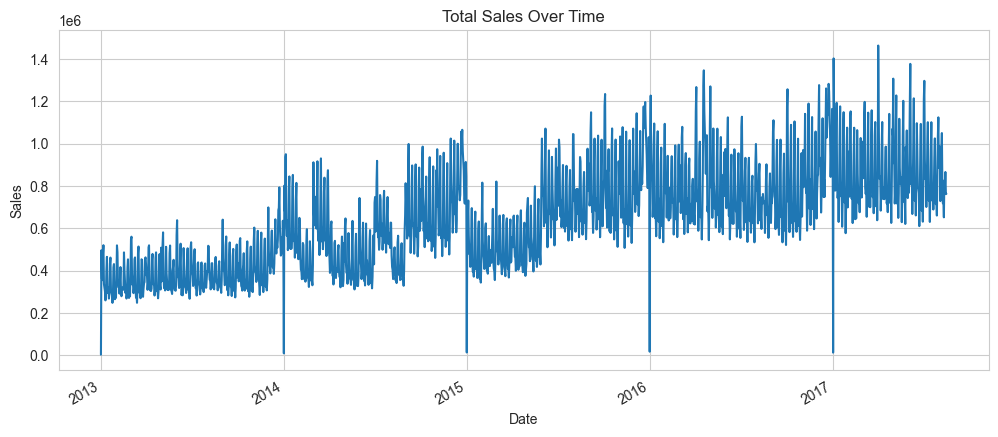

In [8]:
plt.figure(figsize=(12,5))
train.groupby("date")["sales"].sum().plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


Store-Level Sample Plot

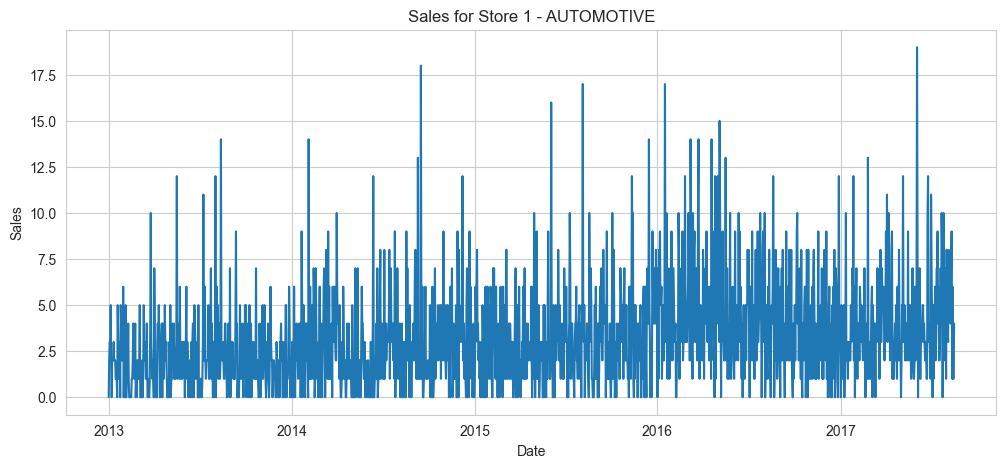

In [9]:
# Pick one store and one family
sample_store = train["store_nbr"].unique()[0]
sample_family = train["family"].unique()[0]

df_sample = train[(train["store_nbr"] == sample_store) & 
                  (train["family"] == sample_family)]

plt.figure(figsize=(12,5))
plt.plot(df_sample["date"], df_sample["sales"])
plt.title(f"Sales for Store {sample_store} - {sample_family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [10]:
train.to_csv("../data/processed/train_eda.csv", index=False)
test.to_csv("../data/processed/test_eda.csv", index=False)

DEEP TIME SERIES EDA

In [11]:
import statsmodels.api as sm
print("statsmodels is installed")

statsmodels is installed


In [12]:

# Time Series Analysis Imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [13]:
# Create daily total sales time series
ts = train.groupby("date")["sales"].sum().reset_index()

ts.set_index("date", inplace=True)

ts.head()


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


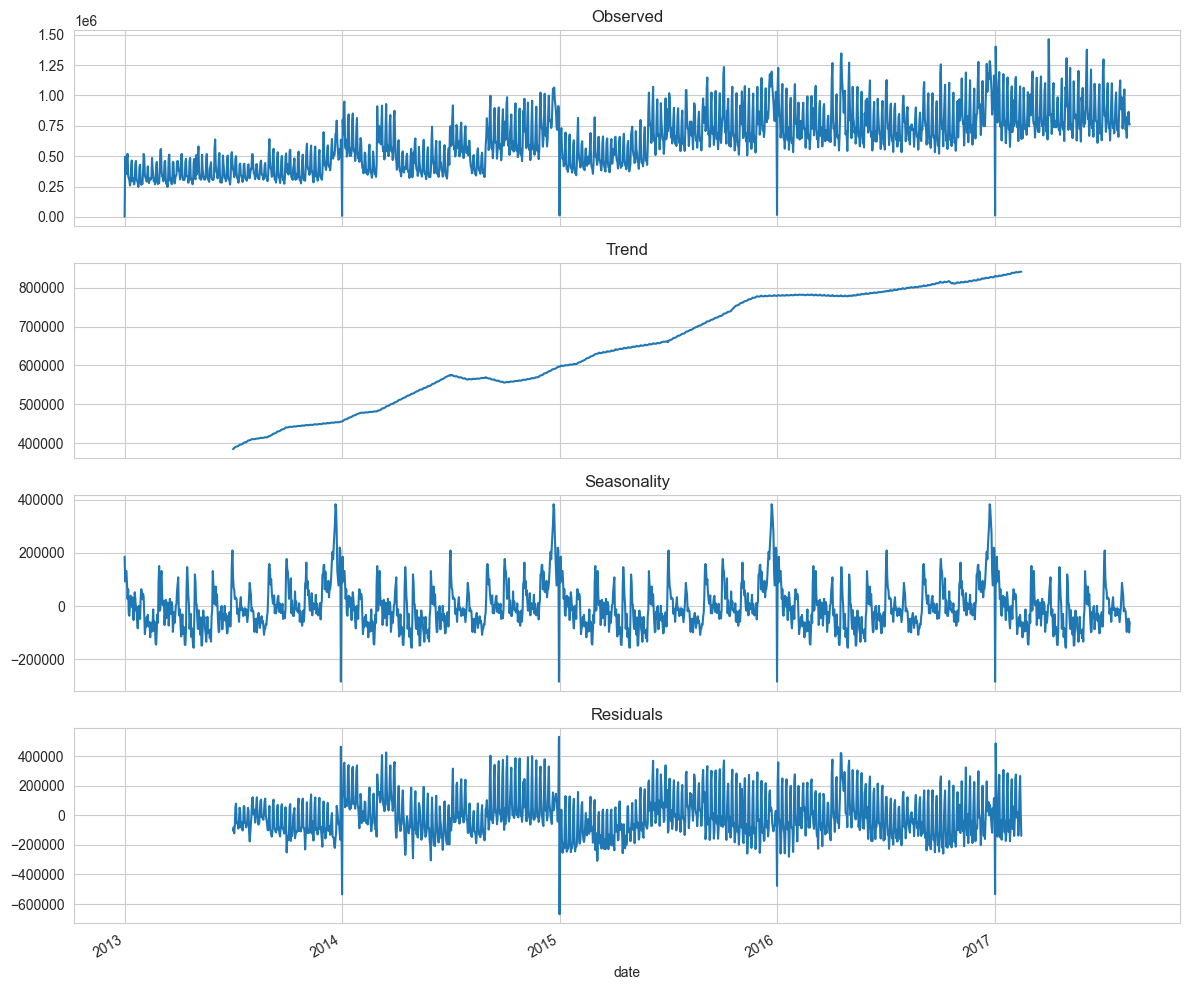

In [14]:
#Plot Trend + Seasonality + Residuals

## Decompose time series
decomposition = seasonal_decompose(ts["sales"], model="additive", period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

decomposition.observed.plot(ax=axes[0])
axes[0].set_title("Observed")

decomposition.trend.plot(ax=axes[1])
axes[1].set_title("Trend")

decomposition.seasonal.plot(ax=axes[2])
axes[2].set_title("Seasonality")

decomposition.resid.plot(ax=axes[3])
axes[3].set_title("Residuals")

plt.tight_layout()
plt.show()


In [15]:
#Check Stationarity

## Augmented Dickey-Fuller Test
result = adfuller(ts["sales"].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Series is STATIONARY")
else:
    print("Series is NON-STATIONARY")


ADF Statistic: -2.6161957486048575
p-value: 0.08969592175787455
Series is NON-STATIONARY


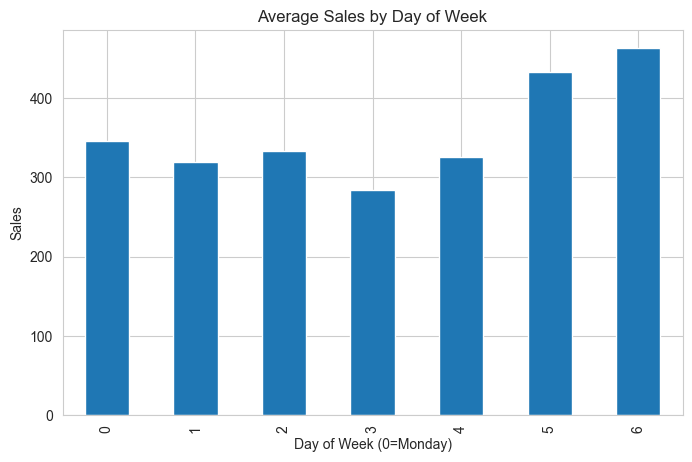

In [16]:
#Weekly Seasonality Check
train["day_of_week"] = train["date"].dt.dayofweek

weekly_sales = train.groupby("day_of_week")["sales"].mean()

plt.figure(figsize=(8,5))
weekly_sales.plot(kind="bar")
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Sales")
plt.show()


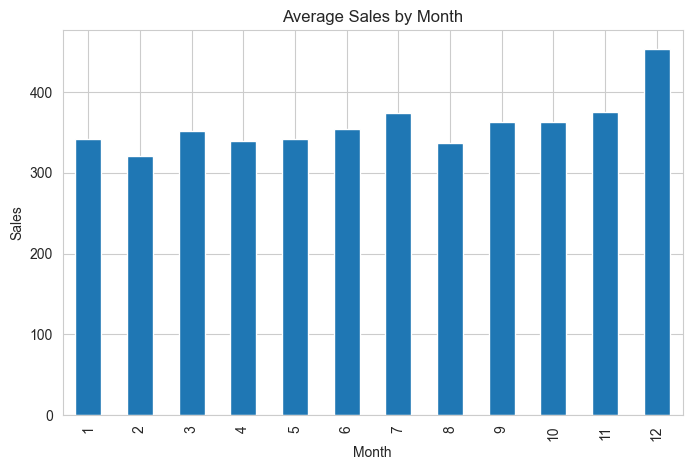

In [17]:
#Monthly Trend Analysis

train["month"] = train["date"].dt.month

monthly_sales = train.groupby("month")["sales"].mean()

plt.figure(figsize=(8,5))
monthly_sales.plot(kind="bar")
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()


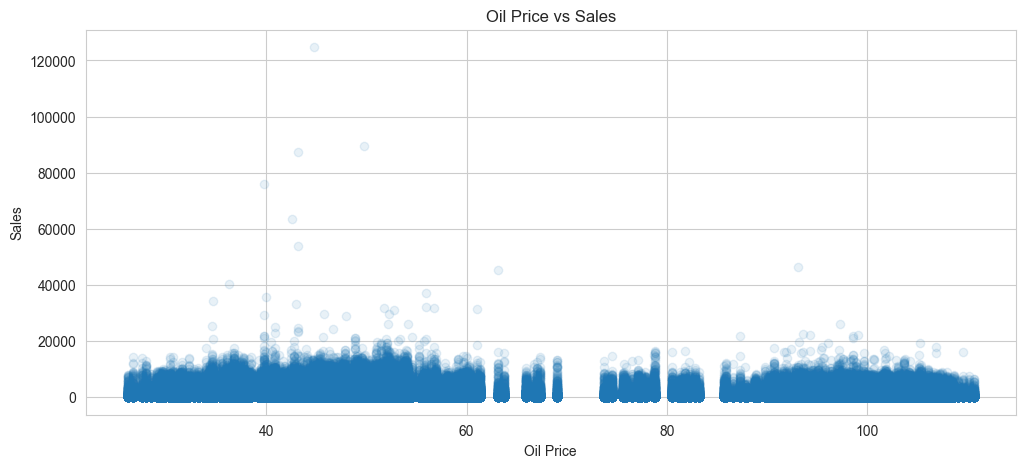

In [18]:
#Impact of Oil Prices on Sales

train_oil = train.merge(oil, on="date", how="left")

plt.figure(figsize=(12,5))
plt.scatter(train_oil["dcoilwtico"], train_oil["sales"], alpha=0.1)
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.title("Oil Price vs Sales")
plt.show()


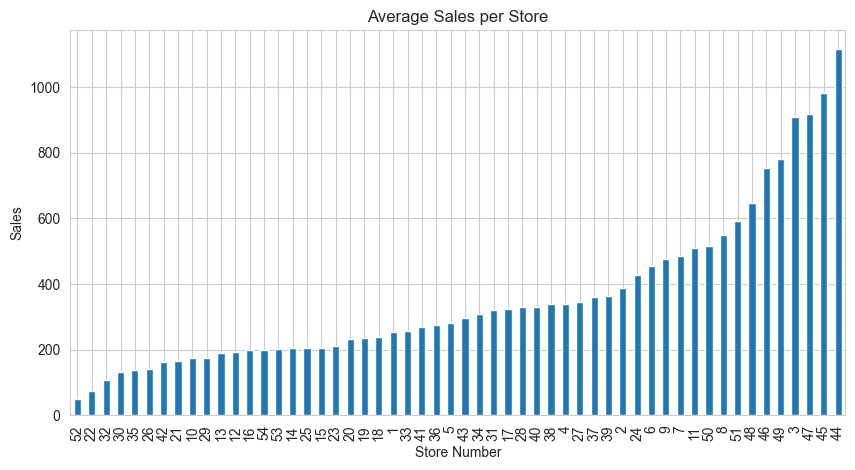

In [19]:
#Store-Level Variability

store_sales = train.groupby("store_nbr")["sales"].mean().sort_values()

plt.figure(figsize=(10,5))
store_sales.plot(kind="bar")
plt.title("Average Sales per Store")
plt.xlabel("Store Number")
plt.ylabel("Sales")
plt.show()


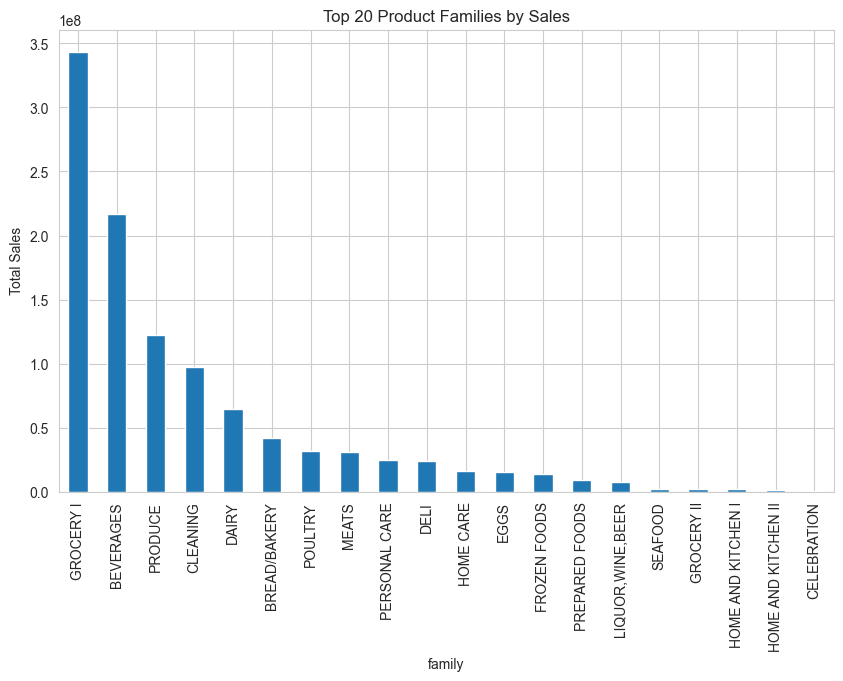

In [20]:
#Family-Level Sales Distribution

family_sales = train.groupby("family")["sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
family_sales.head(20).plot(kind="bar")
plt.title("Top 20 Product Families by Sales")
plt.ylabel("Total Sales")
plt.show()


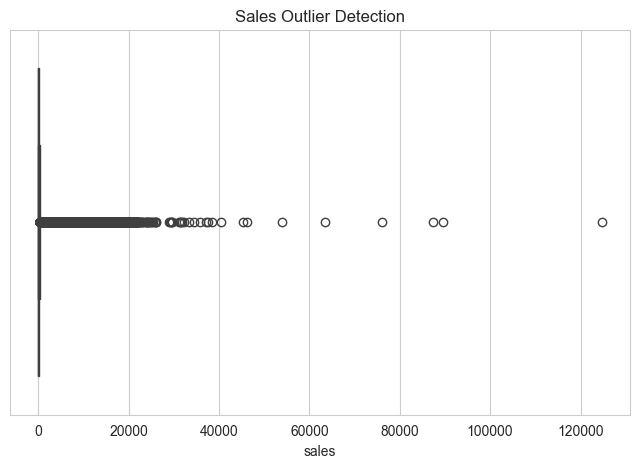

In [21]:
#Check Outliers

plt.figure(figsize=(8,5))
sns.boxplot(x=train["sales"])
plt.title("Sales Outlier Detection")
plt.show()


In [22]:
#Save Enhanced EDA Data
train.to_csv("../data/processed/train_ts_eda.csv", index=False)
